## 패키지 참조

In [58]:
from pandas import DataFrame,read_csv,read_excel,merge,melt,pivot_table
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
import sys
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.cluster.hierarchy import dendrogram,linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_kmo

## 폰트세팅

In [59]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.unicode_minus"] = False

## 데이터

In [60]:
origin=read_excel('행정동병합최종_반포본동.xlsx')
origin.head(2)

,시도명,시군구코드,시군구명,행정동코드,행정동코드_수정,읍면동명,생성일자,말소일자,지하철역_수,의료기관_수,...,세대당공원면적minmax,수변점수,행정동별버스정류장수,행정동별유통업체수,공공자전거대여소수,인구밀도,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,환경자족성지수minmax
0,서울특별시,11110,종로구,1111051500,11110515,청운효자동,20081101,0,0,11,...,0.352898,0,32,0,3,4552.529183,0.002648,0.068435,0.114798,0.212495
1,서울특별시,11110,종로구,1111053000,11110530,사직동,19880423,0,2,75,...,0.063554,0,27,0,12,7611.382114,0.006464,0.041923,0.333275,0.038269


### 분석에 필요한 변수만 추출

`읍면동`, `지수` 추출

In [61]:
origin1=origin.filter(['읍면동명','환경자족성지수minmax','여가생활지수minmax','사회적약자_지원_인프라_밀집도minmax','접근성지수minmax'])
origin1.head(2)

,읍면동명,환경자족성지수minmax,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax
0,청운효자동,0.212495,0.002648,0.068435,0.114798
1,사직동,0.038269,0.006464,0.041923,0.333275


### 이상치/결측치 확인 및 처리

In [62]:
origin1.isna().sum()

읍면동명                      0
환경자족성지수minmax             0
여가생활지수minmax              1
사회적약자_지원_인프라_밀집도minmax    0
접근성지수minmax               0
dtype: int64

In [63]:
origin2=origin1.copy()
origin2=origin1.fillna(0)
origin2.isna().sum()

읍면동명                      0
환경자족성지수minmax             0
여가생활지수minmax              0
사회적약자_지원_인프라_밀집도minmax    0
접근성지수minmax               0
dtype: int64

## #1. `환경자족성지수 - 여가생활지수`

### 변수 추출

In [64]:
origin3=origin2.copy()
origin3_1=origin3.filter(['읍면동명','환경자족성지수minmax','여가생활지수minmax']) # 클러스터링 아이디 붙일 변수
origin3_3=origin3.filter(['환경자족성지수minmax','여가생활지수minmax']) # 계층군집용 변수
origin3_3.head()

,환경자족성지수minmax,여가생활지수minmax
0,0.212495,0.002648
1,0.038269,0.006464
2,0.602143,0.005332
3,0.602143,0.001699
4,0.602861,0.000529


### 계층 군집 수행

`sklearn 패키지`

| 파라미터 | 설명 |
| -- | -- |
| n_clusters | 찾아야 할 클러스터 수(earlystopping과 유사) |
| affinity | 클러스터 간 거리 측정 방법(euclidean, cityblock, manhattan, cosine) |
| linkage | ward(기본값), complete, average, single |
| compute_distances | 노드간의 거리 계산값을 저장할지 여부(시각화를 위해서는 True를 필수 적용) |

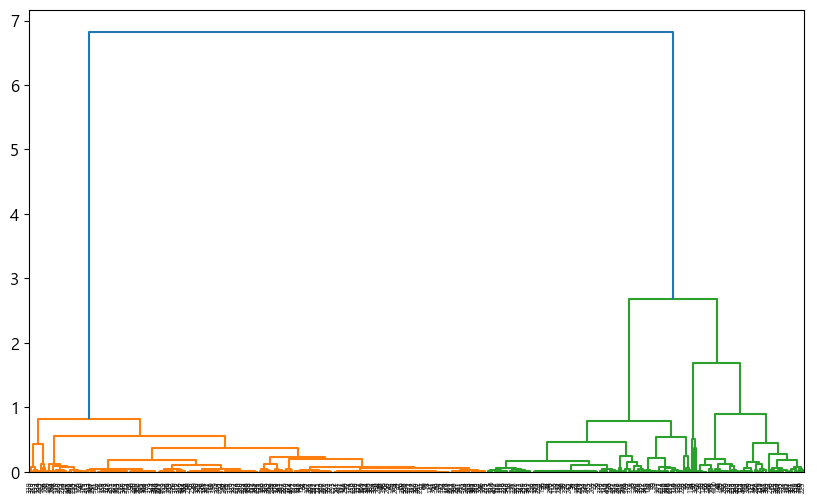

In [65]:
# 모델 객체 생성
ac=AgglomerativeClustering(n_clusters=6,    # 찾아야 할 클러스터 수(earlystopping과 유사)
                           metric='euclidean',  # 클러스터 간 거리 측정 방법
                           linkage='ward',  # 거리측정 방법
                           compute_distances=True   #시각화를 위하 반드시 필요
                           )
# 학습
clustering=ac.fit(origin3_3)

# zeros 모든 원소가 0인 요소 확인
counts=np.zeros(clustering.children_.shape[0])
# labels_ : 각 입력 데이터의 그룹 번호
n_samples=len(clustering.labels_)

# 자식 노드를 반복하면서 점을 찍어준다
# => (자식이 몇개 있는지 확인하는 과정)
for i,merge in enumerate(clustering.children_):
    current_count=0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count +=1 # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i]=current_count

# 자식 노드의 수를 저장하는 배열
linkage_matrix=np.column_stack(
    [clustering.children_,clustering.distances_,counts]
).astype(float)

# plt를 설정하지 않으면 쓸데 없는 값도 함께 추출됨
# dendrogram(linkage_matrix)
plt.figure(figsize=(10,6))
dendrogram(linkage_matrix)
plt.show()
plt.close()

### 군집 결과

In [66]:
clustering.labels_

array([4, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 4, 2, 2, 2, 0,
       0, 2, 2, 2, 4, 2, 2, 2, 2, 3, 2, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 4, 2, 4, 2, 3, 2, 2, 2, 0, 0, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2,
       4, 2, 2, 2, 2, 2, 5, 2, 2, 2, 4, 3, 2, 3, 2, 2, 2, 2, 4, 2, 2, 0,
       0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 3, 3, 2, 2, 0, 4, 0, 0,
       0, 2, 5, 2, 0, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 2, 4, 2, 5, 0, 5, 2, 2, 0, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 2, 2, 2, 2, 2, 2, 0, 0, 0, 3, 2, 2, 2, 3, 2, 5, 2, 2, 2, 2,
       0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 3, 0, 2, 2, 0, 2, 2, 2, 4, 0, 4, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 4, 0, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2,
       2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 5, 0,

### 군집 결과 데이터 병합

In [67]:
origin3_1['labels']=clustering.labels_
origin3_1.head()

,읍면동명,환경자족성지수minmax,여가생활지수minmax,labels
0,청운효자동,0.212495,0.002648,4
1,사직동,0.038269,0.006464,0
2,삼청동,0.602143,0.005332,2
3,부암동,0.602143,0.001699,2
4,평창동,0.602861,0.000529,2


### 군집 결과 지각화

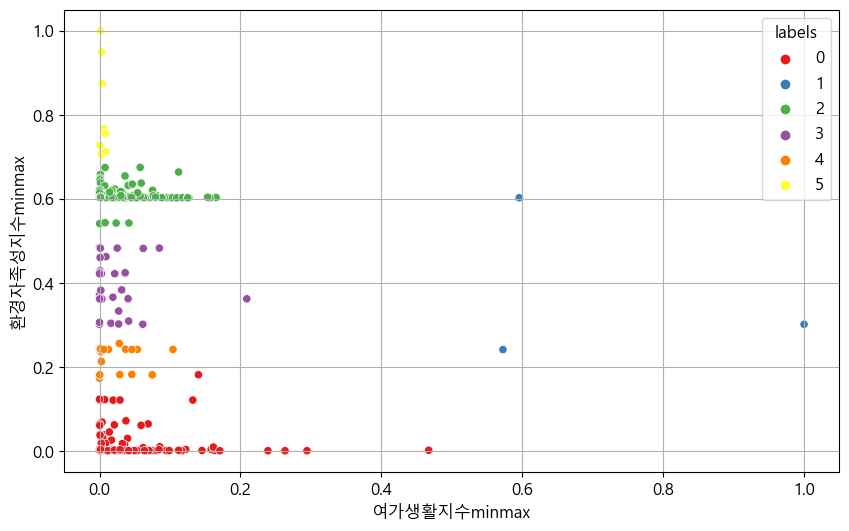

In [68]:
plt.figure(figsize=(10,6))
sb.scatterplot(data=origin3_1,x='여가생활지수minmax',y='환경자족성지수minmax',hue='labels',palette='Set1')
plt.grid()
plt.show()
plt.close()

> - 군집 `1`과 `5`를 분석에 사용
> - `1`은 두 지수가 비교적 긍정적이며 `5`는 하나의 지수가 가장 큰 집단.

### 수동 voting을 위한 xlsx 파일 생성

In [69]:
origin3_1[origin3_1['labels']==1]

,읍면동명,환경자족성지수minmax,여가생활지수minmax,labels
24,신당동,0.301071,1.000000,1
30,황학동,0.602244,0.595757,1
307,청림동,0.240857,0.572641,1


In [70]:
origin3_1[origin3_1['labels']==5]

,읍면동명,환경자족성지수minmax,여가생활지수minmax,labels
94,면목제4동,0.949815,0.003249,5
134,번제2동,0.714229,0.004499,5
160,중계제4동,1.000000,0.001636,5
162,상계제1동,0.874020,0.003907,5
193,홍은제2동,0.705038,0.002983,5
213,상암동,0.726448,0.000708,5
299,사당제2동,0.712265,0.008762,5
339,양재제1동,0.766479,0.005750,5
370,오륜동,0.755072,0.008438,5


In [114]:
origin3_1final=origin3_1[(origin3_1['labels']==1)|(origin3_1['labels']==5)]
origin3_1final.head()

,읍면동명,환경자족성지수minmax,여가생활지수minmax,labels
24,신당동,0.301071,1.000000,1
30,황학동,0.602244,0.595757,1
94,면목제4동,0.949815,0.003249,5
134,번제2동,0.714229,0.004499,5
160,중계제4동,1.000000,0.001636,5


In [116]:
origin3_1final.to_excel('./교집합결과/여가생활,환경자족성지수voting3.xlsx')

## #2. `환경자족성지수 - 사회적약자_지원_인프라_밀집도`

### 변수 추출

In [73]:
origin4=origin2.copy()
origin4_1=origin4.filter(['읍면동명','환경자족성지수minmax','사회적약자_지원_인프라_밀집도minmax']) # 클러스터링 아이디 붙일 변수
origin4_3=origin4.filter(['환경자족성지수minmax','사회적약자_지원_인프라_밀집도minmax']) # 계층군집용 변수
origin4_3.head()

,환경자족성지수minmax,사회적약자_지원_인프라_밀집도minmax
0,0.212495,0.068435
1,0.038269,0.041923
2,0.602143,0.090426
3,0.602143,0.067935
4,0.602861,0.073234


### 계층 군집 수행

`sklearn 패키지`

| 파라미터 | 설명 |
| -- | -- |
| n_clusters | 찾아야 할 클러스터 수(earlystopping과 유사) |
| affinity | 클러스터 간 거리 측정 방법(euclidean, cityblock, manhattan, cosine) |
| linkage | ward(기본값), complete, average, single |
| compute_distances | 노드간의 거리 계산값을 저장할지 여부(시각화를 위해서는 True를 필수 적용) |

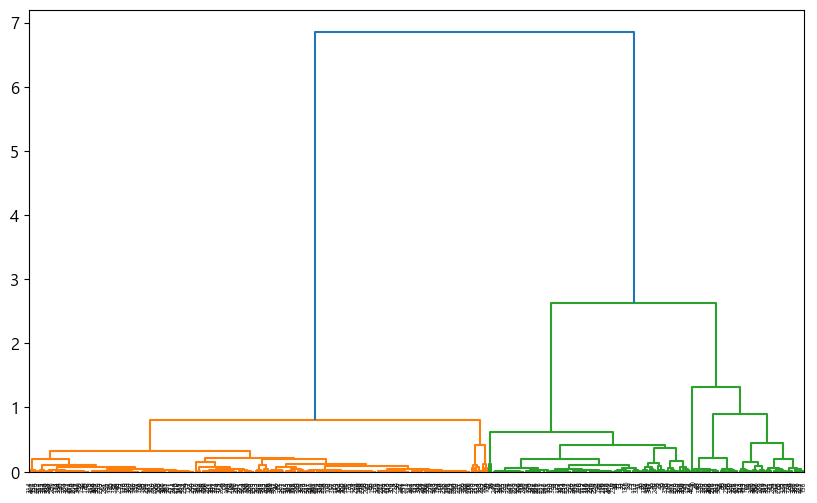

In [74]:
ac2=AgglomerativeClustering(n_clusters=6, metric='euclidean',linkage='ward',compute_distances=True)
clustering2=ac2.fit(origin4_3)

counts=np.zeros(clustering2.children_.shape[0])
n_samples=len(clustering2.labels_)

for i,merge in enumerate(clustering2.children_):
    current_count=0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count +=1 # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i]=current_count

linkage_matrix=np.column_stack(
    [clustering2.children_,clustering2.distances_,counts]
).astype(float)

#plot the corresponding dendrogram
plt.figure(figsize=(10,6))
dendrogram(linkage_matrix)
plt.show()
plt.close()

### 군집 결과

In [75]:
clustering2.labels_

array([4, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 4, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 4, 5, 5, 5, 0,
       0, 5, 5, 5, 4, 5, 5, 5, 5, 1, 5, 1, 0, 5, 5, 5, 5, 5, 5, 5, 5, 1,
       5, 5, 4, 5, 4, 5, 1, 5, 5, 5, 0, 0, 5, 5, 5, 1, 1, 5, 5, 5, 5, 5,
       4, 5, 5, 5, 5, 5, 2, 5, 5, 5, 4, 1, 5, 1, 5, 5, 5, 5, 4, 5, 5, 0,
       0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 5, 0, 5, 1, 1, 5, 5, 0, 4, 0, 0,
       0, 5, 2, 5, 0, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 1, 5, 4, 5, 2, 0, 2, 5, 5, 0, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 1, 5, 5, 5, 5, 5, 5, 0, 0, 0, 1, 5, 5, 5, 1, 5, 2, 5, 5, 5, 5,
       0, 0, 5, 5, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 0, 0, 5, 0,
       0, 0, 0, 0, 0, 1, 0, 5, 5, 0, 5, 5, 5, 4, 0, 4, 0, 0, 0, 0, 0, 0,
       0, 5, 5, 5, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 1, 4, 0, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 1, 5,
       5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 2, 0,

### 군집 결과 데이터 병합

In [76]:
origin4_1['labels']=clustering2.labels_
origin4_1.head()

,읍면동명,환경자족성지수minmax,사회적약자_지원_인프라_밀집도minmax,labels
0,청운효자동,0.212495,0.068435,4
1,사직동,0.038269,0.041923,0
2,삼청동,0.602143,0.090426,5
3,부암동,0.602143,0.067935,5
4,평창동,0.602861,0.073234,5


### 군집 결과 시각화

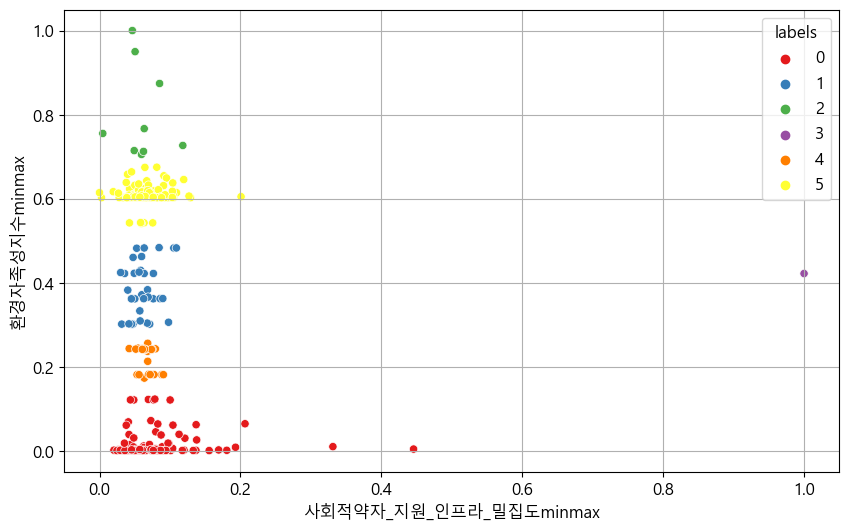

In [77]:
plt.figure(figsize=(10,6))
sb.scatterplot(data=origin4_1,x='사회적약자_지원_인프라_밀집도minmax',y='환경자족성지수minmax',hue='labels',palette='Set1')
plt.grid()
plt.show()
plt.close()

> - `2`번 `3`번을 분석에 사용

### 수동 voting을 위한 xlsx 파일 생성

In [119]:
origin4_1[origin4_1['labels']==3]

,읍면동명,환경자족성지수minmax,사회적약자_지원_인프라_밀집도minmax,labels
403,둔촌제1동,0.4215,1.0,3


In [120]:
# origin4_1final=DataFrame(origin4_1[origin4_1['labels']==1])
origin4_1final=origin4_1[(origin4_1['labels']==2)|(origin4_1['labels']==3)]
origin4_1final.head()

,읍면동명,환경자족성지수minmax,사회적약자_지원_인프라_밀집도minmax,labels
94,면목제4동,0.949815,0.050509,2
134,번제2동,0.714229,0.049283,2
160,중계제4동,1.000000,0.046624,2
162,상계제1동,0.874020,0.085261,2
193,홍은제2동,0.705038,0.059582,2


In [121]:
origin4_1final.to_excel('./교집합결과/사회적약자,환경자족성지수voting3.xlsx')

## #3. `환경자족성지수 - 접근성지수`

### 변수 추출

In [81]:
origin5=origin2.copy()
origin5_1=origin5.filter(['읍면동명','환경자족성지수minmax','접근성지수minmax']) # 클러스터링 아이디 붙일 변수
origin5_3=origin5.filter(['환경자족성지수minmax','접근성지수minmax']) # 계층군집용 변수
origin5_3.head()

,환경자족성지수minmax,접근성지수minmax
0,0.212495,0.114798
1,0.038269,0.333275
2,0.602143,0.342620
3,0.602143,0.157400
4,0.602861,0.135935


### 계층 군집 수행

`sklearn 패키지`

| 파라미터 | 설명 |
| -- | -- |
| n_clusters | 찾아야 할 클러스터 수(earlystopping과 유사) |
| affinity | 클러스터 간 거리 측정 방법(euclidean, cityblock, manhattan, cosine) |
| linkage | ward(기본값), complete, average, single |
| compute_distances | 노드간의 거리 계산값을 저장할지 여부(시각화를 위해서는 True를 필수 적용) |

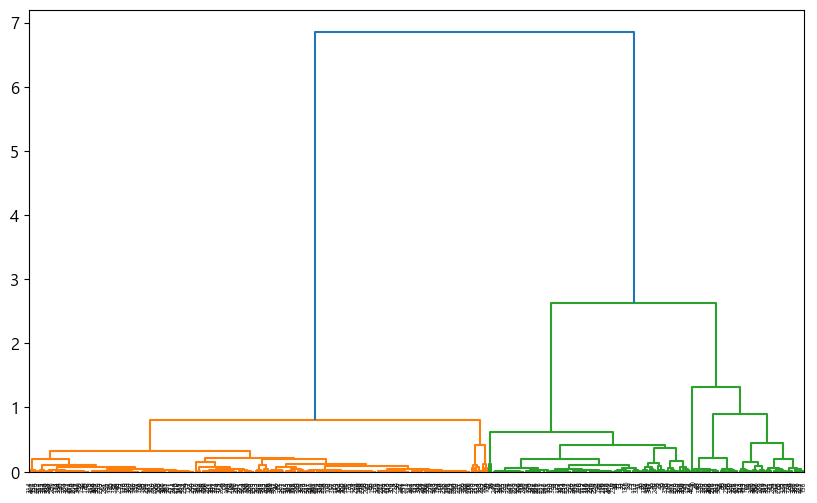

In [82]:
ac3=AgglomerativeClustering(n_clusters=6, metric='euclidean',linkage='ward',compute_distances=True)
clustering3=ac3.fit(origin4_3)

counts=np.zeros(clustering3.children_.shape[0])
n_samples=len(clustering3.labels_)

for i,merge in enumerate(clustering3.children_):
    current_count=0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count +=1 # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i]=current_count

linkage_matrix=np.column_stack(
    [clustering3.children_,clustering3.distances_,counts]
).astype(float)

#plot the corresponding dendrogram
plt.figure(figsize=(10,6))
dendrogram(linkage_matrix)
plt.show()
plt.close()

### 군집 결과

In [83]:
clustering3.labels_

array([4, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 4, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 4, 5, 5, 5, 0,
       0, 5, 5, 5, 4, 5, 5, 5, 5, 1, 5, 1, 0, 5, 5, 5, 5, 5, 5, 5, 5, 1,
       5, 5, 4, 5, 4, 5, 1, 5, 5, 5, 0, 0, 5, 5, 5, 1, 1, 5, 5, 5, 5, 5,
       4, 5, 5, 5, 5, 5, 2, 5, 5, 5, 4, 1, 5, 1, 5, 5, 5, 5, 4, 5, 5, 0,
       0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 5, 0, 5, 1, 1, 5, 5, 0, 4, 0, 0,
       0, 5, 2, 5, 0, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 1, 5, 4, 5, 2, 0, 2, 5, 5, 0, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 1, 5, 5, 5, 5, 5, 5, 0, 0, 0, 1, 5, 5, 5, 1, 5, 2, 5, 5, 5, 5,
       0, 0, 5, 5, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 0, 0, 5, 0,
       0, 0, 0, 0, 0, 1, 0, 5, 5, 0, 5, 5, 5, 4, 0, 4, 0, 0, 0, 0, 0, 0,
       0, 5, 5, 5, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 1, 4, 0, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 1, 5,
       5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 2, 0,

### 군집 결과 데이터 병합

In [84]:
origin5_1['labels']=clustering3.labels_
origin5_1.head()

,읍면동명,환경자족성지수minmax,접근성지수minmax,labels
0,청운효자동,0.212495,0.114798,4
1,사직동,0.038269,0.333275,0
2,삼청동,0.602143,0.342620,5
3,부암동,0.602143,0.157400,5
4,평창동,0.602861,0.135935,5


### 군집 결과 시각화

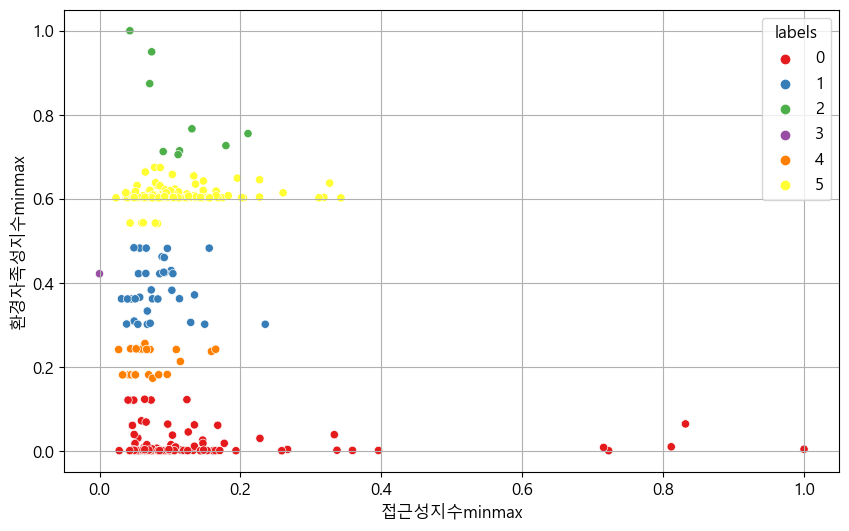

In [85]:
plt.figure(figsize=(10,6))
sb.scatterplot(data=origin5_1,x='접근성지수minmax',y='환경자족성지수minmax',hue='labels',palette='Set1')
plt.grid()
plt.show()
plt.close()

> 비교적 긍정적이고 군집이 잘 이루어진 `1`을 분석에 사용

### 수동 voting을 위한 xlsx 파일 생성

In [125]:
len(origin5_1[origin5_1['labels']==1])

34

In [126]:
origin5_1final=DataFrame(origin5_1[origin5_1['labels']==1])
origin5_1final.head()

,읍면동명,환경자족성지수minmax,접근성지수minmax,labels
15,숭인제1동,0.370980,0.134867,1
24,신당동,0.301071,0.235243,1
53,행당제2동,0.361708,0.075154,1
55,금호1가동,0.429124,0.101611,1
65,화양동,0.421500,0.085524,1


In [127]:
origin5_1final.to_excel('./교집합결과/접근성지수,환경자족성지수voting3.xlsx')

## #4. `여가생활지수 - 사회적약자_지원_인프라_밀집도`

In [90]:
origin6=origin2.copy()
origin6_1=origin6.filter(['읍면동명','여가생활지수minmax','사회적약자_지원_인프라_밀집도minmax']) # 클러스터링 아이디 붙일 변수
origin6_3=origin6.filter(['여가생활지수minmax','사회적약자_지원_인프라_밀집도minmax']) # 계층군집용 변수
origin6_3.head()

,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax
0,0.002648,0.068435
1,0.006464,0.041923
2,0.005332,0.090426
3,0.001699,0.067935
4,0.000529,0.073234


### 계층 군집 수행

`sklearn 패키지`

| 파라미터 | 설명 |
| -- | -- |
| n_clusters | 찾아야 할 클러스터 수(earlystopping과 유사) |
| affinity | 클러스터 간 거리 측정 방법(euclidean, cityblock, manhattan, cosine) |
| linkage | ward(기본값), complete, average, single |
| compute_distances | 노드간의 거리 계산값을 저장할지 여부(시각화를 위해서는 True를 필수 적용) |

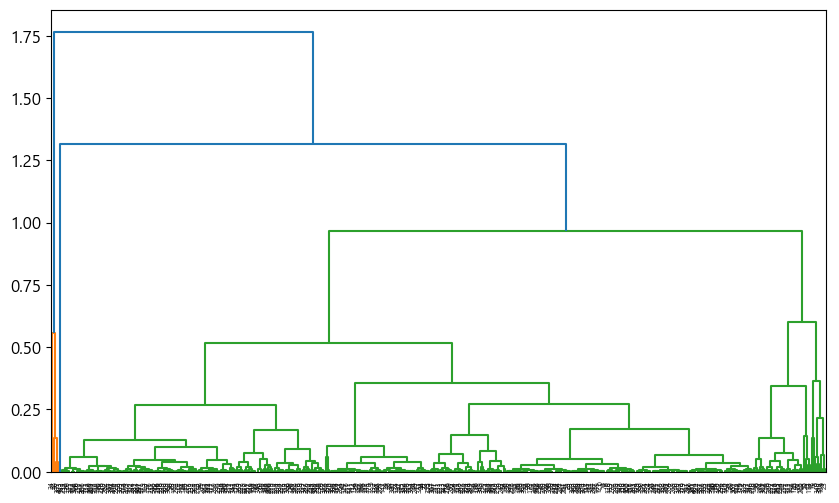

In [128]:
ac4=AgglomerativeClustering(n_clusters=4, metric='euclidean',linkage='ward',compute_distances=True)
clustering4=ac4.fit(origin6_3)

counts=np.zeros(clustering4.children_.shape[0])
n_samples=len(clustering4.labels_)

for i,merge in enumerate(clustering4.children_):
    current_count=0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count +=1 # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i]=current_count

linkage_matrix=np.column_stack(
    [clustering4.children_,clustering4.distances_,counts]
).astype(float)

#plot the corresponding dendrogram
plt.figure(figsize=(10,6))
dendrogram(linkage_matrix)
plt.show()
plt.close()

### 군집 결과

In [129]:
clustering4.labels_

array([3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 0, 3, 3, 3, 0, 0, 0, 0, 3, 3,
       1, 0, 1, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 0, 3, 0, 0, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0,
       3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3,
       3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 0, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

### 군집 결과 데이터 병합

In [130]:
origin6_1['labels']=clustering4.labels_
origin6_1.head()

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,labels
0,청운효자동,0.002648,0.068435,3
1,사직동,0.006464,0.041923,3
2,삼청동,0.005332,0.090426,3
3,부암동,0.001699,0.067935,3
4,평창동,0.000529,0.073234,3


### 군집 결과 시각화

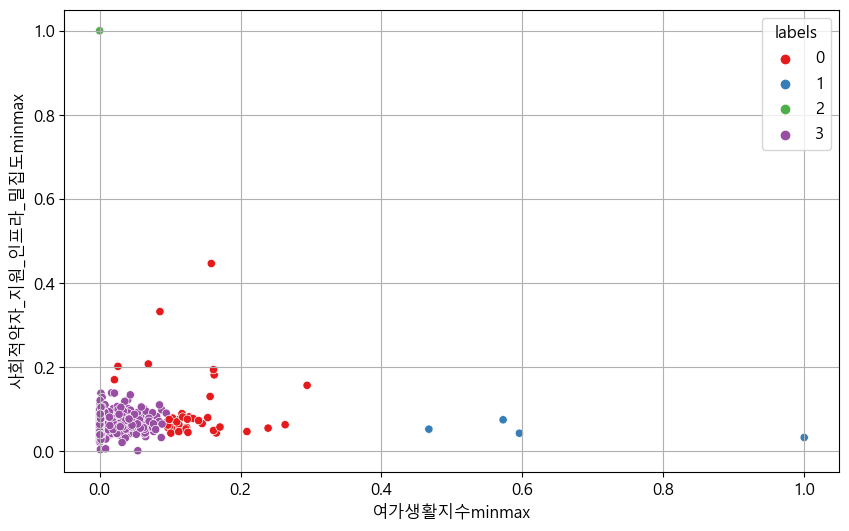

In [131]:
plt.figure(figsize=(10,6))
sb.scatterplot(data=origin6_1,x='여가생활지수minmax',y='사회적약자_지원_인프라_밀집도minmax',hue='labels',palette='Set1')
plt.grid()
plt.show()
plt.close()

### 수동 voting을 위한 xlsx 파일 생성

In [133]:
len(origin6_1[origin6_1['labels']==0])

38

In [134]:
origin6_1final=DataFrame(origin6_1[origin6_1['labels']==0])
origin6_1final.head()

,읍면동명,여가생활지수minmax,사회적약자_지원_인프라_밀집도minmax,labels
8,종로1.2.3.4가동,0.069040,0.206536,0
9,종로5.6가동,0.162506,0.180645,0
12,창신제1동,0.263260,0.061943,0
16,숭인제2동,0.165488,0.042236,0
17,소공동,0.085553,0.331262,0


In [135]:
origin6_1final.to_excel('./교집합결과/여가생활,사회적약자voting3.xlsx')

## #5. `여가생활지수 - 접근성지수`

In [98]:
origin7=origin2.copy()
origin7_1=origin7.filter(['읍면동명','여가생활지수minmax','접근성지수minmax']) # 클러스터링 아이디 붙일 변수
origin7_3=origin7.filter(['여가생활지수minmax','접근성지수minmax']) # 계층군집용 변수
origin7_3.head()

,여가생활지수minmax,접근성지수minmax
0,0.002648,0.114798
1,0.006464,0.333275
2,0.005332,0.342620
3,0.001699,0.157400
4,0.000529,0.135935


### 계층 군집 수행

`sklearn 패키지`

| 파라미터 | 설명 |
| -- | -- |
| n_clusters | 찾아야 할 클러스터 수(earlystopping과 유사) |
| affinity | 클러스터 간 거리 측정 방법(euclidean, cityblock, manhattan, cosine) |
| linkage | ward(기본값), complete, average, single |
| compute_distances | 노드간의 거리 계산값을 저장할지 여부(시각화를 위해서는 True를 필수 적용) |

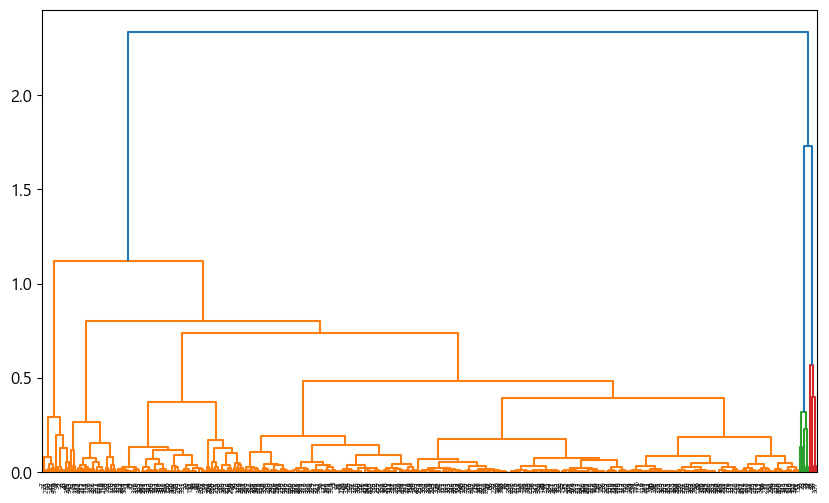

In [99]:
ac5=AgglomerativeClustering(n_clusters=6, metric='euclidean',linkage='ward',compute_distances=True)
clustering5=ac5.fit(origin7_3)

counts=np.zeros(clustering5.children_.shape[0])
n_samples=len(clustering5.labels_)

for i,merge in enumerate(clustering5.children_):
    current_count=0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count +=1 # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i]=current_count

linkage_matrix=np.column_stack(
    [clustering5.children_,clustering5.distances_,counts]
).astype(float)

#plot the corresponding dendrogram
plt.figure(figsize=(10,6))
dendrogram(linkage_matrix)
plt.show()
plt.close()

### 군집 결과

In [100]:
clustering5.labels_

array([1, 3, 3, 2, 2, 1, 1, 3, 5, 3, 3, 1, 4, 1, 2, 2, 4, 5, 5, 5, 3, 3,
       0, 5, 0, 1, 4, 1, 1, 1, 0, 1, 1, 2, 3, 1, 1, 1, 2, 1, 3, 1, 1, 2,
       1, 2, 2, 1, 1, 1, 1, 2, 2, 4, 1, 1, 1, 2, 1, 2, 1, 1, 3, 1, 2, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2,
       1, 1, 1, 4, 2, 4, 4, 1, 1, 4, 4, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4,
       1, 1, 4, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 4, 4, 1, 4,
       1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 4, 1, 1, 1, 1, 4, 1,
       2, 3, 2, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### 군집 결과 데이터 통합

In [101]:
origin7_1['labels']=clustering5.labels_
origin7_1.head()

,읍면동명,여가생활지수minmax,접근성지수minmax,labels
0,청운효자동,0.002648,0.114798,1
1,사직동,0.006464,0.333275,3
2,삼청동,0.005332,0.342620,3
3,부암동,0.001699,0.157400,2
4,평창동,0.000529,0.135935,2


### 군집 결과 시각화

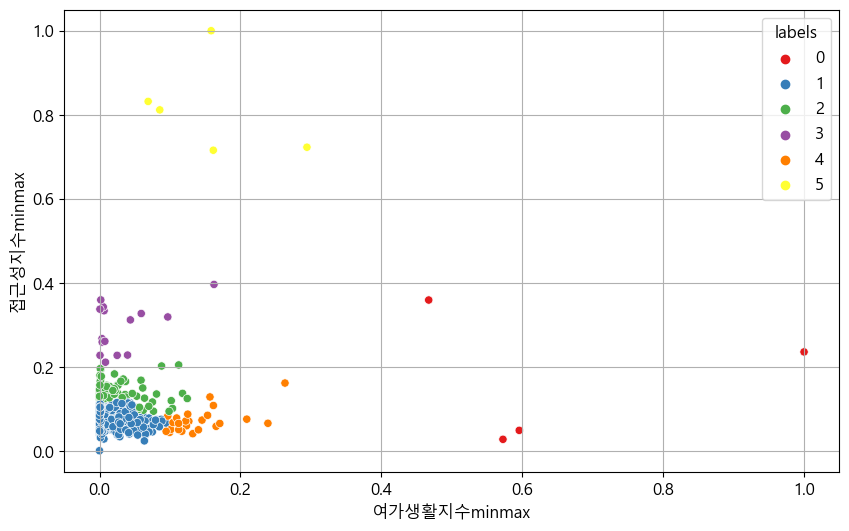

In [102]:
plt.figure(figsize=(10,6))
sb.scatterplot(data=origin7_1,x='여가생활지수minmax',y='접근성지수minmax',hue='labels',palette='Set1')
plt.grid()
plt.show()
plt.close()

### 수동 voting을 위한 xlsx 파일 생성

In [137]:
sum = len(origin7_1[origin7_1['labels']==5]) + len(origin7_1[origin7_1['labels']==0])
sum

9

In [138]:
origin7_1_1final=origin7_1[(origin7_1['labels']==0)|(origin7_1['labels']==5)]
origin7_1_1final.head()

,읍면동명,여가생활지수minmax,접근성지수minmax,labels
8,종로1.2.3.4가동,0.069040,0.831703,5
17,소공동,0.085553,0.811509,5
18,회현동,0.294433,0.722658,5
19,명동,0.158472,1.000000,5
22,광희동,0.467260,0.358815,0


In [139]:
origin7_1.to_excel('./교집합결과/여가생활,접근성지수voting3.xlsx')

## #6. `사회적약자_지원_인프라_밀집도 - 접근성지수`

### 변수 추출

In [106]:
origin8=origin2.copy()
origin8_1=origin8.filter(['읍면동명','사회적약자_지원_인프라_밀집도minmax','접근성지수minmax']) # 클러스터링 아이디 붙일 변수
origin8_3=origin8.filter(['사회적약자_지원_인프라_밀집도minmax','접근성지수minmax']) # 계층군집용 변수
origin8_3.head()

,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax
0,0.068435,0.114798
1,0.041923,0.333275
2,0.090426,0.342620
3,0.067935,0.157400
4,0.073234,0.135935


### 계층 군집 수행

`sklearn 패키지`

| 파라미터 | 설명 |
| -- | -- |
| n_clusters | 찾아야 할 클러스터 수(earlystopping과 유사) |
| affinity | 클러스터 간 거리 측정 방법(euclidean, cityblock, manhattan, cosine) |
| linkage | ward(기본값), complete, average, single |
| compute_distances | 노드간의 거리 계산값을 저장할지 여부(시각화를 위해서는 True를 필수 적용) |

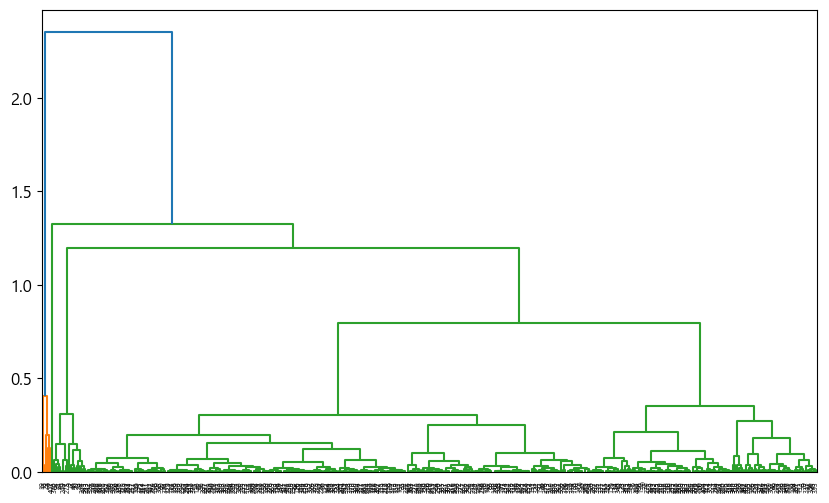

In [154]:
ac6=AgglomerativeClustering(n_clusters=6, metric='euclidean',linkage='ward',compute_distances=True)
clustering6=ac6.fit(origin8_3)

counts=np.zeros(clustering6.children_.shape[0])
n_samples=len(clustering6.labels_)

for i,merge in enumerate(clustering6.children_):
    current_count=0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count +=1 # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i]=current_count

linkage_matrix=np.column_stack(
    [clustering6.children_,clustering6.distances_,counts]
).astype(float)

#plot the corresponding dendrogram
plt.figure(figsize=(10,6))
dendrogram(linkage_matrix)
plt.show()
plt.close()

### 군집 결과

In [155]:
clustering6.labels_

array([0, 1, 1, 0, 0, 4, 0, 1, 3, 1, 1, 0, 0, 4, 0, 0, 4, 3, 3, 5, 1, 1,
       1, 3, 1, 4, 0, 4, 4, 4, 4, 4, 4, 0, 1, 4, 4, 0, 0, 4, 1, 4, 4, 0,
       4, 0, 0, 4, 4, 4, 0, 0, 0, 4, 0, 4, 4, 0, 0, 0, 0, 4, 1, 4, 0, 4,
       4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 0,
       4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 0, 4, 4, 0, 4, 4, 4, 0,
       0, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4,
       4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4, 0, 4, 4, 0, 0,
       4, 0, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 0, 0, 0, 4, 0, 0, 4, 4, 0, 4, 4, 0, 4, 4, 4, 4,
       4, 4, 0, 4, 0, 0, 4, 0, 0, 0, 4, 0, 4, 4, 4, 0, 0, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4,
       4, 1, 4, 4, 0, 4, 4, 4, 0, 4, 0, 0, 4, 0, 4, 4, 4, 4, 4, 4, 4, 0,
       0, 1, 0, 4, 4, 4, 4, 4, 4, 4, 0, 1, 0, 0, 4, 0, 0, 4, 4, 4, 4, 4,
       4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

### 군집 결과 데이터 병합

In [156]:
origin8_1['labels']=clustering6.labels_
origin8_1.head()

,읍면동명,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,labels
0,청운효자동,0.068435,0.114798,0
1,사직동,0.041923,0.333275,1
2,삼청동,0.090426,0.342620,1
3,부암동,0.067935,0.157400,0
4,평창동,0.073234,0.135935,0


### 군집 결과 시각화

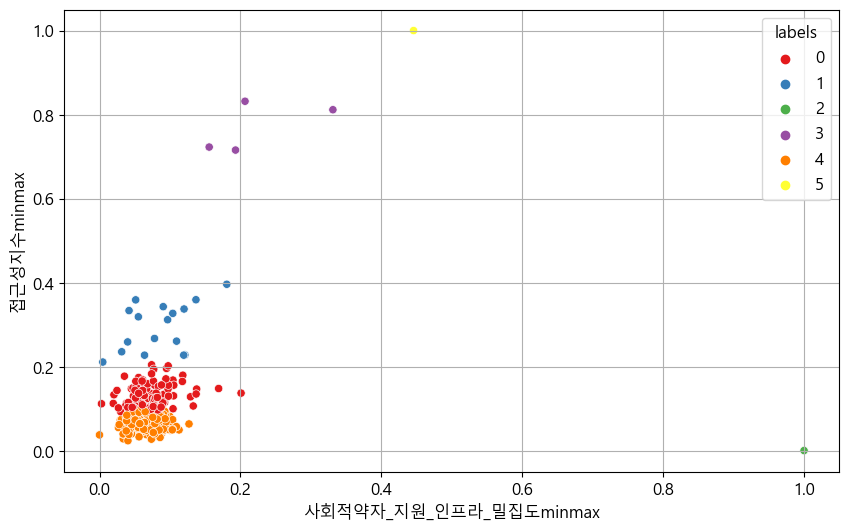

In [157]:
plt.figure(figsize=(10,6))
sb.scatterplot(data=origin8_1,x='사회적약자_지원_인프라_밀집도minmax',y='접근성지수minmax',hue='labels',palette='Set1')
plt.grid()
plt.show()
plt.close()

> `1`, `3`, `5`를 사용하기로 결정

### 수동 voting을 위한 xlsx 파일 생성

In [160]:
origin8_1[origin8_1['labels']==1]

,읍면동명,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,labels
1,사직동,0.041923,0.333275,1
2,삼청동,0.090426,0.342620,1
7,가회동,0.078064,0.266902,1
9,종로5.6가동,0.180645,0.395959,1
10,이화동,0.121190,0.227733,1
20,필동,0.119991,0.337055,1
21,장충동,0.039973,0.258683,1
22,광희동,0.051345,0.358815,1
24,신당동,0.031490,0.235243,1
34,남영동,0.136880,0.359116,1


In [161]:
origin8_1final=origin8_1[(origin8_1['labels']==1)|(origin8_1['labels']==3)|(origin8_1['labels']==5)]
origin8_1final.head()

,읍면동명,사회적약자_지원_인프라_밀집도minmax,접근성지수minmax,labels
1,사직동,0.041923,0.333275,1
2,삼청동,0.090426,0.342620,1
7,가회동,0.078064,0.266902,1
8,종로1.2.3.4가동,0.206536,0.831703,3
9,종로5.6가동,0.180645,0.395959,1


In [113]:
origin8_1final.to_excel('./교집합결과/사회적약자,접근성지수voting3.xlsx')